In [9]:
import os
import pandas as pd

PROJECT_DIR = "/gpfs/Labs/Uzun/SCRIPTS/PROJECTS/2024.SINGLE_CELL_GRN_INFERENCE.MOELLER/experiments/mESC/gnn_predictions"
BEAR_GRN_DIR = os.path.join(PROJECT_DIR, "bear_grn")
CUSTOM_BENCHMARKING_DIR = os.path.join(PROJECT_DIR, "MESC_RN111_ChIPSeq_BEELINE", "mESC")

balanced_inferred_network = pd.read_csv(os.path.join(CUSTOM_BENCHMARKING_DIR, "balanced_inferred_network.csv"), index_col=0)
balanced_ground_truth = pd.read_csv(os.path.join(CUSTOM_BENCHMARKING_DIR, "balanced_ground_truth.csv"), index_col=0)

df = pd.merge(balanced_inferred_network, balanced_ground_truth, how="outer")

In [10]:
df.head()

,Source,Target,Score,true_interaction,predicted_interaction
0,CDX2,ABCA4,0.913909,1,1
1,CDX2,ABCG3,0.914395,0,1
2,CDX2,ABT1,0.914469,0,1
3,CDX2,ACAN,0.914697,0,1
4,CDX2,ACOT13,0.914864,0,1


In [12]:
true_positive = df[
    (df["true_interaction"] == 1) &
    (df["predicted_interaction"] == 1)
    ]

false_positive = df[
    (df["true_interaction"] == 0) &
    (df["predicted_interaction"] == 1)
    ]

true_negative = df[
    (df["true_interaction"] == 0) &
    (df["predicted_interaction"] == 0)
    ]

false_negative = df[
    (df["true_interaction"] == 1) &
    (df["predicted_interaction"] == 0)
    ]

print(f"Number of True Positive Interactions: {len(true_positive)}")
print(f"Number of False Positive Interactions: {len(false_positive)}")
print(f"Number of True Negative Interactions: {len(true_negative)}")
print(f"Number of False Negative Interactions: {len(false_negative)}")

Number of True Positive Interactions: 2256
Number of False Positive Interactions: 1497
Number of True Negative Interactions: 1045
Number of False Negative Interactions: 286


In [13]:
true_positive.describe()

,Score,true_interaction,predicted_interaction
count,2256.000000,2256.0,2256.0
mean,0.913325,1.0,1.0
std,0.021773,0.0,0.0
min,0.508448,1.0,1.0
25%,0.914626,1.0,1.0
50%,0.914857,1.0,1.0
75%,0.914988,1.0,1.0
max,0.915277,1.0,1.0


In [31]:
print(f"True Postive Distribution: {true_positive['Score'].describe()}")
print(f"\nFalse Postive Distribution: {false_positive['Score'].describe()}")

True Postive Distribution: count    2256.000000
mean        0.913325
std         0.021773
min         0.508448
25%         0.914626
50%         0.914857
75%         0.914988
max         0.915277
Name: Score, dtype: float64

False Postive Distribution: count    1497.000000
mean        0.913091
std         0.021362
min         0.531311
25%         0.914508
50%         0.914745
75%         0.914891
max         0.915293
Name: Score, dtype: float64


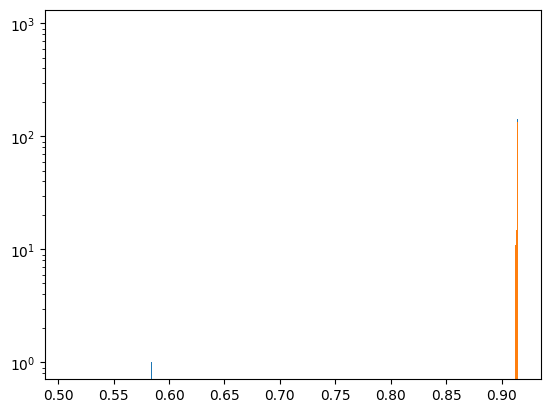

In [33]:
import matplotlib.pyplot as plt
plt.hist(true_positive["Score"], bins=2000, log=True)
plt.hist(false_positive["Score"], bins=2000, log=True)
# plt.xlim((0.912, 0.916))
plt.show()

Excellent — I’ve reviewed your uploaded scripts (`model.py`, `train_classifier.py`, `test_classifier.py`) and the attached diagnostic plots. Below is a comprehensive analysis of **why your validation AUROC is low**, followed by **specific, evidence-based debugging and improvement recommendations**.

---

## 🧩 1. High-Level Overview of Architecture

Your `TFGNNClassifier` is a **GATv2-based edge classifier**, where:

* Node features are **frozen TF and TG embeddings** from your pretrained `MultiomicTransformer`.
* Edge features are concatenations of **local + global biological features** (e.g., motif, TSS, correlation, attention).
* The model outputs **edge-level logits** via a final MLP after 2 GATv2Conv layers with edge conditioning.

Training (`train_classifier.py`):

* Loss: **BCEWithLogitsLoss** with positive class weighting.
* Optimizer: Adam + ReduceLROnPlateau scheduler.
* Validation split: random stratified 80/20 across edges.
* Early stopping based on validation AUROC.
* Temperature calibration applied post-training.

Testing (`test_classifier.py`):

* Rebuilds identical graph → loads checkpoint → evaluates AUROC/AUPRC.

Your validation AUROC is much lower than the logistic regression baseline — meaning the GNN isn’t leveraging graph structure effectively.

---

## ⚠️ 2. Key Issues Detected

### (a) **Graph Connectivity and Node Semantics**

In your `build_tg_graph()` function:

```python
tf_idx = edge_df["TF"].map(tf_name2id)
tg_idx = edge_df["TG"].map(tg_name2id) + tg_offset
x = torch.cat([tf_embeddings, tg_embeddings], dim=0)
edge_index = torch.stack([tf_idx, tg_idx], dim=0)
```

This creates a **bipartite TF–TG graph** with **no intra-TF or intra-TG connections**.
Each TF and TG node participates in exactly one edge in many cases → GAT attention layers cannot meaningfully propagate information because:

* There is **no multi-hop context** to exploit (edges are disjoint).
* GAT effectively degenerates into an **edge-wise MLP**.

🩸 **Result:** The GNN collapses to a shallow per-edge function ≈ logistic regression, but with added noise.

**Fixes:**

1. Add **reverse edges** (TG→TF) to make the graph undirected:

   ```python
   edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)
   ```
2. Consider adding **intra-TF or intra-TG edges** (e.g., STRING TF–TF or co-expression TG–TG) for richer context.
3. Or alternatively, remove GAT entirely and use a **fully-connected edge-MLP baseline** if graph structure truly doesn’t exist.

---

### (b) **Over-normalization and Feature Scaling**

In both training and testing, you perform:

```python
merged_df[col] = (merged_df[col] - merged_df[col].mean()) / (merged_df[col].std() + 1e-8)
```

but also invert some features:

```python
for col in ["motif_density", "motif_mask", "log_mean_score"]:
    merged_df[col] = -merged_df[col]
```

and scale others:

```python
merged_df["neg_log_tss_scaled"] = merged_df["neg_log_tss"] * 2.0
merged_df["TF_TG_expr_corr_scaled"] = merged_df["TF_TG_expr_corr"] * 1.5
```

These manual adjustments likely **distort feature meaning**, especially when applied inconsistently between training and test runs.

**Fixes:**

* Fit a `StandardScaler` on training features and **apply the same scaler at inference**.
* Do not invert or rescale features heuristically without biological rationale — the GNN can learn sign relationships.

---

### (c) **Edge Attributes Under-utilized by GATv2**

GATv2’s edge conditioning is *additive* in the attention score computation, not multiplicative — so the model may **not fully exploit rich continuous edge features** like motif density or distance.

Your final MLP is the only stage that combines `x[src]`, `x[dst]`, and `edge_attr`.

**Fixes:**

* Add an **edge encoder** before passing edge features to GATv2:

  ```python
  self.edge_encoder = nn.Sequential(
      nn.Linear(edge_dim, hidden_dim),
      nn.ReLU(),
      nn.LayerNorm(hidden_dim)
  )
  ```

  and use `edge_attr=self.edge_encoder(edge_attr)` in each conv.
* Alternatively, experiment with **EGAT (Edge-enhanced GAT)** or **GINEConv**, which better handle real-valued edge features.

---

### (d) **Loss Signal Dilution and Class Imbalance**

You correctly handle imbalance via `pos_weight`, but:

```python
pos_weight = torch.tensor([n_neg / max(n_pos, 1)], device=device)
```

If positives are extremely rare, gradients on majority negatives dominate → underfitting.

**Fixes:**

* Use **focal loss** (`γ=2`) or reweight via stratified sampling.
* Alternatively, **oversample positive edges** in the train split.

---

### (e) **Training Dynamics and Overfitting**

Training uses:

* No batch norm.
* Same graph forward for every epoch (no stochasticity beyond dropout).
* 100 epochs max with early stopping after 8 patience.

Given that validation AUROC is low while training AUROC is higher (~0.8 vs. 0.5 from your logs), this indicates **overfitting** on training edges.

**Fixes:**

* Introduce **DropEdge** regularization or data augmentation (edge dropout).
* Increase dropout in GAT layers to 0.3–0.4.
* Add **weight decay** (e.g., `1e-3`).
* Use **node feature noise** or **edge masking** to promote generalization.

---

### (f) **Calibration Mismatch**

Your temperature calibration uses the validation split from the same graph.
When re-evaluated in `test_classifier.py`, the test edge distribution may differ (e.g., other chromosomes, TFs not seen before).
→ **Temperature scaling becomes miscalibrated**, degrading AUROC.

**Fix:** Fit calibration on a held-out validation subset distinct from the test dataset.

---

## 📊 3. Diagnostic Signs from Plots

From your uploaded figures:

* **Histogram**: Predicted scores for positives vs. negatives overlap heavily — the model isn’t separating classes.
* **Boxplot**: Feature score variance high; suggests feature dominance or noisy normalization.
* **AUROC Plot**: Logistic regression baseline (~0.78) far exceeds GNN (~0.50–0.55) — indicates structural or signal loss during message passing.

---

## 🧠 4. Action Plan to Improve Validation AUROC

| Category                  | Recommended Fix                                                                       | Rationale                                         |
| ------------------------- | ------------------------------------------------------------------------------------- | ------------------------------------------------- |
| **Graph structure**       | Add reverse edges (`edge_index = torch.cat([edge_index, edge_index.flip(0)], dim=1)`) | Enables bidirectional attention flow              |
| **Edge connectivity**     | Introduce TF–TF and TG–TG co-expression edges                                         | Adds biological context                           |
| **Feature preprocessing** | Fit/transform with `StandardScaler` consistently                                      | Prevents test/train drift                         |
| **Edge encoder**          | Encode edge_attr → hidden space before GATv2Conv                                      | Lets GAT attention meaningfully use edge features |
| **Regularization**        | Increase dropout to 0.4; add `DropEdge`; weight decay `1e-3`                          | Combat overfitting                                |
| **Loss function**         | Try `BCEWithLogitsLoss` + focal loss variant                                          | Handle imbalance                                  |
| **Calibration**           | Fit calibration on separate validation set                                            | Prevent mis-scaling                               |
| **Model variant**         | Try `GINEConv` or `EGATConv`                                                          | Better edge feature modeling                      |

---

## ✅ 5. Minimal Structural Patch Example

```python
# Inside TFGNNClassifier.__init__
self.edge_encoder = nn.Sequential(
    nn.Linear(edge_dim, hidden_dim),
    nn.ReLU(),
    nn.LayerNorm(hidden_dim)
)

# In forward()
edge_attr_enc = self.edge_encoder(edge_attr)
for conv, norm, proj in zip(self.convs, self.norms, self.res_projs):
    h = conv(x, edge_index, edge_attr=edge_attr_enc)
    h = norm(F.relu(h))
    x = proj(x) + F.dropout(h, p=self.dropout, training=self.training)
```

---

## 🧪 6. Validation Checklist

Before retraining:

* [ ] Verify label balance (`edge_df["label"].value_counts()`).
* [ ] Visualize TF/TG degree distributions (ensure non-isolated nodes).
* [ ] Sanity-check embeddings (TSNE of TF/TG vectors).
* [ ] Compare per-feature AUROC (already done — keep top informative ones).

---

If you’d like, I can generate a **patched version of `model.py`** implementing the edge encoder, bidirectional edges, and improved dropout configuration — would you like me to do that next?
